[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [18]:
! nvidia-smi

Tue Jun 27 03:37:51 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:1E.0     Off |                    0 |
| N/A   53C    P0    73W / 149W |      0MiB / 11439MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [4]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomHealthGathering-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

[2017-06-26 20:29:13,683] Making new env: ppaquette/DoomHealthGathering-v0


In [5]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 5

5.0 False


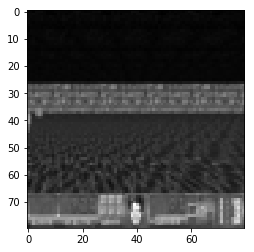

In [6]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [7]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [8]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [9]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [10]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [11]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [12]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 20:29:14,508] Making new env: ppaquette/DoomHealthGathering-v0


In [15]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[0 0 3 0 0 3 0]]
[[ 5.  5.  5.  5.  5.  5.  0.]]
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 84.7 ms


In [16]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [17]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [18]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [19]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [20]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 20:29:31,378] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:29:31,387] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-06-26 20:29:31,630] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14410.video000000.mp4


Episode finished after 75 timesteps with reward=271.0


[2017-06-26 20:29:33,225] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14410.video000001.mp4


Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0


[2017-06-26 20:29:40,913] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14410.video000008.mp4


Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0


[2017-06-26 20:29:43,533] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 75 timesteps with reward=271.0


In [21]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [22]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [23]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:01<04:10,  7.94it/s]

iter=10	epsilon=0.954	reward/step=4.00000


  1%|          | 20/2000 [00:02<04:20,  7.59it/s]

iter=20	epsilon=0.910	reward/step=2.96190


  2%|▏         | 30/2000 [00:03<04:12,  7.81it/s]

iter=30	epsilon=0.868	reward/step=3.29677


  2%|▏         | 40/2000 [00:04<04:09,  7.85it/s]

iter=40	epsilon=0.828	reward/step=2.93659


  2%|▏         | 49/2000 [00:06<03:59,  8.16it/s][2017-06-26 20:29:49,784] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:29:49,789] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=3.14510


[2017-06-26 20:29:51,117] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  3%|▎         | 51/2000 [00:07<13:10,  2.47it/s]

Episode finished after 81 timesteps with reward=303.0


  3%|▎         | 61/2000 [00:08<04:13,  7.65it/s]

iter=60	epsilon=0.754	reward/step=2.92787


  4%|▎         | 71/2000 [00:10<04:10,  7.70it/s]

iter=70	epsilon=0.719	reward/step=3.07887


  4%|▍         | 81/2000 [00:11<04:21,  7.34it/s]

iter=80	epsilon=0.687	reward/step=2.92346


  5%|▍         | 91/2000 [00:12<04:23,  7.25it/s]

iter=90	epsilon=0.656	reward/step=3.04176


  5%|▍         | 99/2000 [00:14<04:35,  6.89it/s][2017-06-26 20:29:57,832] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:29:57,840] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=3.13663


[2017-06-26 20:29:59,506] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 101/2000 [00:16<15:46,  2.01it/s]

Episode finished after 107 timesteps with reward=431.0


  6%|▌         | 111/2000 [00:17<05:08,  6.12it/s]

iter=110	epsilon=0.598	reward/step=3.02342


  6%|▌         | 121/2000 [00:19<05:03,  6.19it/s]

iter=120	epsilon=0.571	reward/step=3.10413


  7%|▋         | 131/2000 [00:20<05:07,  6.07it/s]

iter=130	epsilon=0.546	reward/step=3.01221


  7%|▋         | 141/2000 [00:22<05:13,  5.93it/s]

iter=140	epsilon=0.522	reward/step=3.08227


  7%|▋         | 149/2000 [00:23<05:11,  5.94it/s][2017-06-26 20:30:07,747] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:30:07,756] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=2.99868


[2017-06-26 20:30:09,013] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 151/2000 [00:25<13:25,  2.30it/s]

Episode finished after 75 timesteps with reward=271.0


  8%|▊         | 161/2000 [00:27<05:29,  5.58it/s]

iter=160	epsilon=0.477	reward/step=3.06087


  9%|▊         | 171/2000 [00:29<05:15,  5.80it/s]

iter=170	epsilon=0.456	reward/step=2.98830


  9%|▉         | 181/2000 [00:30<05:15,  5.76it/s]

iter=180	epsilon=0.436	reward/step=3.04420


 10%|▉         | 191/2000 [00:32<05:23,  5.59it/s]

iter=190	epsilon=0.417	reward/step=3.09424


 10%|▉         | 199/2000 [00:34<05:28,  5.48it/s][2017-06-26 20:30:17,879] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:30:17,887] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=3.03085


[2017-06-26 20:30:19,141] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 201/2000 [00:35<13:23,  2.24it/s]

Episode finished after 75 timesteps with reward=271.0


 11%|█         | 211/2000 [00:37<05:42,  5.22it/s]

iter=210	epsilon=0.382	reward/step=3.07678


 11%|█         | 221/2000 [00:39<05:30,  5.38it/s]

iter=220	epsilon=0.366	reward/step=3.01991


 12%|█▏        | 231/2000 [00:41<05:31,  5.34it/s]

iter=230	epsilon=0.351	reward/step=3.06234


 12%|█▏        | 241/2000 [00:43<05:31,  5.30it/s]

iter=240	epsilon=0.336	reward/step=3.01328


 12%|█▏        | 249/2000 [00:44<05:41,  5.13it/s][2017-06-26 20:30:28,615] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:30:28,624] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=3.05259


[2017-06-26 20:30:30,122] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 13%|█▎        | 251/2000 [00:46<14:59,  1.95it/s]

Episode finished after 94 timesteps with reward=367.0


 13%|█▎        | 261/2000 [00:48<05:55,  4.89it/s]

iter=260	epsilon=0.309	reward/step=3.00536


 14%|█▎        | 271/2000 [00:50<05:47,  4.97it/s]

iter=270	epsilon=0.296	reward/step=3.04207


 14%|█▍        | 281/2000 [00:52<05:54,  4.86it/s]

iter=280	epsilon=0.284	reward/step=2.99858


 15%|█▍        | 291/2000 [00:54<05:59,  4.75it/s]

iter=290	epsilon=0.273	reward/step=3.03299


 15%|█▍        | 299/2000 [00:56<06:03,  4.67it/s][2017-06-26 20:30:40,460] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:30:40,465] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=2.98933


[2017-06-26 20:30:41,712] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 301/2000 [00:58<13:20,  2.12it/s]

Episode finished after 75 timesteps with reward=271.0


 16%|█▌        | 311/2000 [01:00<05:28,  5.14it/s]

iter=310	epsilon=0.252	reward/step=2.98933


 16%|█▌        | 321/2000 [01:02<05:18,  5.27it/s]

iter=320	epsilon=0.242	reward/step=2.98933


 17%|█▋        | 331/2000 [01:04<05:17,  5.25it/s]

iter=330	epsilon=0.232	reward/step=2.98933


 17%|█▋        | 341/2000 [01:05<05:15,  5.26it/s]

iter=340	epsilon=0.224	reward/step=2.98933


 17%|█▋        | 349/2000 [01:07<05:14,  5.25it/s][2017-06-26 20:30:51,292] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:30:51,297] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=2.98933


[2017-06-26 20:30:52,539] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 351/2000 [01:09<12:28,  2.20it/s]

Episode finished after 75 timesteps with reward=271.0


 18%|█▊        | 361/2000 [01:11<05:23,  5.07it/s]

iter=360	epsilon=0.207	reward/step=2.99000


 19%|█▊        | 371/2000 [01:12<05:11,  5.22it/s]

iter=370	epsilon=0.199	reward/step=2.99000


 19%|█▉        | 381/2000 [01:14<05:11,  5.19it/s]

iter=380	epsilon=0.192	reward/step=3.06267


 20%|█▉        | 391/2000 [01:16<05:06,  5.24it/s]

iter=390	epsilon=0.185	reward/step=3.06267


 20%|█▉        | 399/2000 [01:18<05:11,  5.14it/s][2017-06-26 20:31:02,239] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:02,243] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=3.06267


[2017-06-26 20:31:03,492] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 401/2000 [01:20<12:11,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 21%|██        | 411/2000 [01:21<05:08,  5.14it/s]

iter=410	epsilon=0.172	reward/step=3.06200


 21%|██        | 421/2000 [01:23<04:56,  5.33it/s]

iter=420	epsilon=0.166	reward/step=3.06200


 22%|██▏       | 431/2000 [01:25<04:57,  5.27it/s]

iter=430	epsilon=0.161	reward/step=3.06000


 22%|██▏       | 441/2000 [01:27<04:56,  5.25it/s]

iter=440	epsilon=0.155	reward/step=3.06000


 22%|██▏       | 449/2000 [01:29<04:57,  5.21it/s][2017-06-26 20:31:13,066] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:13,071] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=3.06000


[2017-06-26 20:31:14,321] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 23%|██▎       | 451/2000 [01:30<11:48,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 23%|██▎       | 461/2000 [01:32<05:08,  5.00it/s]

iter=460	epsilon=0.145	reward/step=3.06000


 24%|██▎       | 471/2000 [01:34<04:54,  5.20it/s]

iter=470	epsilon=0.141	reward/step=3.06000


 24%|██▍       | 481/2000 [01:36<04:50,  5.22it/s]

iter=480	epsilon=0.136	reward/step=3.06000


 25%|██▍       | 491/2000 [01:38<04:47,  5.25it/s]

iter=490	epsilon=0.132	reward/step=2.98733


 25%|██▍       | 499/2000 [01:40<04:52,  5.14it/s][2017-06-26 20:31:24,037] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:24,042] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=3.06000


[2017-06-26 20:31:25,294] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 501/2000 [01:41<11:28,  2.18it/s]

Episode finished after 75 timesteps with reward=271.0


 26%|██▌       | 511/2000 [01:43<04:54,  5.06it/s]

iter=510	epsilon=0.124	reward/step=2.98800


 26%|██▌       | 521/2000 [01:45<04:41,  5.25it/s]

iter=520	epsilon=0.121	reward/step=3.06067


 27%|██▋       | 531/2000 [01:47<04:35,  5.33it/s]

iter=530	epsilon=0.117	reward/step=3.06067


 27%|██▋       | 541/2000 [01:49<04:34,  5.32it/s]

iter=540	epsilon=0.114	reward/step=3.06067


 27%|██▋       | 549/2000 [01:51<04:34,  5.29it/s][2017-06-26 20:31:34,898] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:34,903] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=3.06067


[2017-06-26 20:31:36,099] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 551/2000 [01:52<10:40,  2.26it/s]

Episode finished after 75 timesteps with reward=271.0


 28%|██▊       | 561/2000 [01:54<04:40,  5.13it/s]

iter=560	epsilon=0.108	reward/step=3.06200


 29%|██▊       | 571/2000 [01:56<04:31,  5.25it/s]

iter=570	epsilon=0.105	reward/step=3.06200


 29%|██▉       | 581/2000 [01:58<04:24,  5.36it/s]

iter=580	epsilon=0.102	reward/step=3.13467


 30%|██▉       | 591/2000 [02:00<04:19,  5.42it/s]

iter=590	epsilon=0.100	reward/step=3.13467


 30%|██▉       | 599/2000 [02:01<04:26,  5.26it/s][2017-06-26 20:31:45,644] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:45,649] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=3.13533


[2017-06-26 20:31:47,166] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 601/2000 [02:03<11:57,  1.95it/s]

Episode finished after 94 timesteps with reward=367.0


 31%|███       | 611/2000 [02:05<04:31,  5.11it/s]

iter=610	epsilon=0.095	reward/step=3.13533


 31%|███       | 621/2000 [02:07<04:22,  5.24it/s]

iter=620	epsilon=0.093	reward/step=3.13600


 32%|███▏      | 631/2000 [02:09<04:15,  5.36it/s]

iter=630	epsilon=0.091	reward/step=3.13600


 32%|███▏      | 641/2000 [02:11<04:14,  5.33it/s]

iter=640	epsilon=0.089	reward/step=3.13667


 32%|███▏      | 649/2000 [02:12<04:22,  5.15it/s][2017-06-26 20:31:56,738] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:31:56,743] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=3.13667


[2017-06-26 20:31:58,925] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 33%|███▎      | 651/2000 [02:15<14:42,  1.53it/s]

Episode finished after 151 timesteps with reward=655.0


 33%|███▎      | 661/2000 [02:17<04:34,  4.88it/s]

iter=660	epsilon=0.085	reward/step=3.20867


 34%|███▎      | 671/2000 [02:19<04:10,  5.31it/s]

iter=670	epsilon=0.083	reward/step=3.20867


 34%|███▍      | 681/2000 [02:21<04:12,  5.23it/s]

iter=680	epsilon=0.082	reward/step=3.13667


 35%|███▍      | 691/2000 [02:23<04:11,  5.21it/s]

iter=690	epsilon=0.080	reward/step=3.13667


 35%|███▍      | 699/2000 [02:24<04:12,  5.15it/s][2017-06-26 20:32:08,646] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:32:08,650] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=3.13667


[2017-06-26 20:32:10,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 701/2000 [02:27<12:37,  1.72it/s]

Episode finished after 126 timesteps with reward=527.0


 36%|███▌      | 711/2000 [02:28<04:17,  5.01it/s]

iter=710	epsilon=0.077	reward/step=3.13800


 36%|███▌      | 721/2000 [02:30<03:59,  5.35it/s]

iter=720	epsilon=0.076	reward/step=3.13800


 37%|███▋      | 731/2000 [02:32<03:59,  5.30it/s]

iter=730	epsilon=0.075	reward/step=3.13733


 37%|███▋      | 741/2000 [02:34<04:00,  5.24it/s]

iter=740	epsilon=0.073	reward/step=3.13733


 37%|███▋      | 749/2000 [02:36<03:58,  5.24it/s][2017-06-26 20:32:20,071] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:32:20,076] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=3.21000


[2017-06-26 20:32:21,322] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 751/2000 [02:37<09:25,  2.21it/s]

Episode finished after 75 timesteps with reward=271.0


 38%|███▊      | 761/2000 [02:39<04:04,  5.07it/s]

iter=760	epsilon=0.071	reward/step=3.21000


 39%|███▊      | 771/2000 [02:41<03:52,  5.29it/s]

iter=770	epsilon=0.070	reward/step=3.21067


 39%|███▉      | 781/2000 [02:43<03:52,  5.24it/s]

iter=780	epsilon=0.069	reward/step=3.21067


 40%|███▉      | 791/2000 [02:45<03:43,  5.42it/s]

iter=790	epsilon=0.068	reward/step=3.28333


 40%|███▉      | 799/2000 [02:47<03:51,  5.19it/s][2017-06-26 20:32:30,923] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:32:30,927] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=3.21133


[2017-06-26 20:32:32,161] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 801/2000 [02:48<09:03,  2.20it/s]

Episode finished after 75 timesteps with reward=271.0


 41%|████      | 811/2000 [02:50<03:52,  5.11it/s]

iter=810	epsilon=0.067	reward/step=3.21067


 41%|████      | 821/2000 [02:52<03:45,  5.23it/s]

iter=820	epsilon=0.066	reward/step=3.21067


 42%|████▏     | 831/2000 [02:54<03:42,  5.25it/s]

iter=830	epsilon=0.065	reward/step=3.21067


 42%|████▏     | 841/2000 [02:56<03:41,  5.23it/s]

iter=840	epsilon=0.064	reward/step=3.28133


 42%|████▏     | 849/2000 [02:57<03:38,  5.27it/s][2017-06-26 20:32:41,811] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:32:41,815] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=3.28133


[2017-06-26 20:32:44,090] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 43%|████▎     | 851/2000 [03:00<12:48,  1.50it/s]

Episode finished after 151 timesteps with reward=655.0


 43%|████▎     | 861/2000 [03:02<03:51,  4.92it/s]

iter=860	epsilon=0.063	reward/step=3.28133


 44%|████▎     | 871/2000 [03:04<03:29,  5.38it/s]

iter=870	epsilon=0.062	reward/step=3.28133


 44%|████▍     | 881/2000 [03:06<03:29,  5.34it/s]

iter=880	epsilon=0.062	reward/step=3.20933


 45%|████▍     | 891/2000 [03:08<03:25,  5.39it/s]

iter=890	epsilon=0.061	reward/step=3.20933


 45%|████▍     | 899/2000 [03:09<03:26,  5.33it/s][2017-06-26 20:32:53,561] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:32:53,566] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=3.20867


[2017-06-26 20:32:57,406] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 901/2000 [03:13<18:19,  1.00s/it]

Episode finished after 267 timesteps with reward=1231.0


 46%|████▌     | 911/2000 [03:15<03:48,  4.76it/s]

iter=910	epsilon=0.060	reward/step=3.20867


 46%|████▌     | 921/2000 [03:17<03:21,  5.34it/s]

iter=920	epsilon=0.060	reward/step=3.28067


 47%|████▋     | 931/2000 [03:19<03:23,  5.25it/s]

iter=930	epsilon=0.059	reward/step=3.21067


 47%|████▋     | 941/2000 [03:21<03:23,  5.22it/s]

iter=940	epsilon=0.059	reward/step=3.28267


 47%|████▋     | 949/2000 [03:23<03:22,  5.19it/s][2017-06-26 20:33:07,034] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:33:07,039] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=3.28267


[2017-06-26 20:33:08,288] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 951/2000 [03:24<07:58,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 48%|████▊     | 961/2000 [03:26<03:24,  5.09it/s]

iter=960	epsilon=0.058	reward/step=3.28267


 49%|████▊     | 971/2000 [03:28<03:15,  5.25it/s]

iter=970	epsilon=0.057	reward/step=3.21000


 49%|████▉     | 981/2000 [03:30<03:14,  5.25it/s]

iter=980	epsilon=0.057	reward/step=3.28200


 50%|████▉     | 991/2000 [03:32<03:07,  5.38it/s]

iter=990	epsilon=0.057	reward/step=3.28200


 50%|████▉     | 999/2000 [03:34<03:12,  5.20it/s][2017-06-26 20:33:17,904] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:33:17,909] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=3.21067


[2017-06-26 20:33:19,160] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1001/2000 [03:35<07:35,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 51%|█████     | 1011/2000 [03:37<03:12,  5.14it/s]

iter=1010	epsilon=0.056	reward/step=3.20800


 51%|█████     | 1021/2000 [03:39<03:06,  5.25it/s]

iter=1020	epsilon=0.056	reward/step=3.20800


 52%|█████▏    | 1031/2000 [03:41<03:02,  5.31it/s]

iter=1030	epsilon=0.056	reward/step=3.20800


 52%|█████▏    | 1041/2000 [03:43<02:58,  5.38it/s]

iter=1040	epsilon=0.055	reward/step=3.20800


 52%|█████▏    | 1049/2000 [03:44<02:58,  5.34it/s][2017-06-26 20:33:28,717] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:33:28,722] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=3.20800


[2017-06-26 20:33:29,981] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 53%|█████▎    | 1051/2000 [03:46<07:09,  2.21it/s]

Episode finished after 75 timesteps with reward=271.0


 53%|█████▎    | 1061/2000 [03:48<03:03,  5.11it/s]

iter=1060	epsilon=0.055	reward/step=3.13667


 54%|█████▎    | 1071/2000 [03:50<02:56,  5.25it/s]

iter=1070	epsilon=0.055	reward/step=3.20867


 54%|█████▍    | 1081/2000 [03:52<02:51,  5.36it/s]

iter=1080	epsilon=0.054	reward/step=3.20867


 55%|█████▍    | 1091/2000 [03:54<02:52,  5.26it/s]

iter=1090	epsilon=0.054	reward/step=3.13667


 55%|█████▍    | 1099/2000 [03:55<02:53,  5.19it/s][2017-06-26 20:33:39,576] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:33:39,581] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=3.20867


[2017-06-26 20:33:40,830] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1101/2000 [03:57<06:49,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 56%|█████▌    | 1111/2000 [03:59<02:54,  5.09it/s]

iter=1110	epsilon=0.054	reward/step=3.21000


 56%|█████▌    | 1121/2000 [04:01<02:45,  5.32it/s]

iter=1120	epsilon=0.054	reward/step=3.21000


 57%|█████▋    | 1131/2000 [04:03<02:42,  5.36it/s]

iter=1130	epsilon=0.053	reward/step=3.21000


 57%|█████▋    | 1141/2000 [04:05<02:43,  5.26it/s]

iter=1140	epsilon=0.053	reward/step=3.13933


 57%|█████▋    | 1149/2000 [04:06<02:44,  5.18it/s][2017-06-26 20:33:50,432] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:33:50,437] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=3.13933


[2017-06-26 20:33:51,689] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 58%|█████▊    | 1151/2000 [04:08<06:28,  2.18it/s]

Episode finished after 75 timesteps with reward=271.0


 58%|█████▊    | 1161/2000 [04:10<02:46,  5.04it/s]

iter=1160	epsilon=0.053	reward/step=3.21067


 59%|█████▊    | 1171/2000 [04:12<02:36,  5.28it/s]

iter=1170	epsilon=0.053	reward/step=3.13800


 59%|█████▉    | 1181/2000 [04:14<02:35,  5.28it/s]

iter=1180	epsilon=0.053	reward/step=3.21000


 60%|█████▉    | 1191/2000 [04:15<02:33,  5.27it/s]

iter=1190	epsilon=0.052	reward/step=3.13800


 60%|█████▉    | 1199/2000 [04:17<02:34,  5.17it/s][2017-06-26 20:34:01,337] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:01,341] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=3.21067


[2017-06-26 20:34:02,591] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1201/2000 [04:19<06:04,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 61%|██████    | 1211/2000 [04:21<02:34,  5.12it/s]

iter=1210	epsilon=0.052	reward/step=3.13867


 61%|██████    | 1221/2000 [04:23<02:28,  5.25it/s]

iter=1220	epsilon=0.052	reward/step=3.13867


 62%|██████▏   | 1231/2000 [04:24<02:24,  5.31it/s]

iter=1230	epsilon=0.052	reward/step=3.13600


 62%|██████▏   | 1241/2000 [04:26<02:24,  5.26it/s]

iter=1240	epsilon=0.052	reward/step=3.13600


 62%|██████▏   | 1249/2000 [04:28<02:22,  5.27it/s][2017-06-26 20:34:12,210] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:12,215] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=3.06333


[2017-06-26 20:34:13,459] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 63%|██████▎   | 1251/2000 [04:30<05:40,  2.20it/s]

Episode finished after 75 timesteps with reward=271.0


 63%|██████▎   | 1261/2000 [04:31<02:27,  5.01it/s]

iter=1260	epsilon=0.052	reward/step=3.06333


 64%|██████▎   | 1271/2000 [04:33<02:19,  5.24it/s]

iter=1270	epsilon=0.052	reward/step=3.13600


 64%|██████▍   | 1281/2000 [04:35<02:14,  5.34it/s]

iter=1280	epsilon=0.052	reward/step=3.13600


 65%|██████▍   | 1291/2000 [04:37<02:12,  5.35it/s]

iter=1290	epsilon=0.052	reward/step=3.06533


 65%|██████▍   | 1299/2000 [04:39<02:16,  5.14it/s][2017-06-26 20:34:23,110] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:23,115] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=3.13667


[2017-06-26 20:34:24,358] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1301/2000 [04:40<05:18,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 66%|██████▌   | 1311/2000 [04:42<02:16,  5.04it/s]

iter=1310	epsilon=0.051	reward/step=3.13933


 66%|██████▌   | 1321/2000 [04:44<02:06,  5.35it/s]

iter=1320	epsilon=0.051	reward/step=3.13933


 67%|██████▋   | 1331/2000 [04:46<02:07,  5.26it/s]

iter=1330	epsilon=0.051	reward/step=3.13933


 67%|██████▋   | 1341/2000 [04:48<02:05,  5.24it/s]

iter=1340	epsilon=0.051	reward/step=3.13933


 67%|██████▋   | 1349/2000 [04:50<02:05,  5.19it/s][2017-06-26 20:34:33,980] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:33,984] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=3.06800


[2017-06-26 20:34:35,234] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1351/2000 [04:51<04:54,  2.20it/s]

Episode finished after 75 timesteps with reward=271.0


 68%|██████▊   | 1361/2000 [04:53<02:04,  5.14it/s]

iter=1360	epsilon=0.051	reward/step=3.13933


 69%|██████▊   | 1371/2000 [04:55<01:57,  5.36it/s]

iter=1370	epsilon=0.051	reward/step=3.06667


 69%|██████▉   | 1381/2000 [04:57<01:57,  5.25it/s]

iter=1380	epsilon=0.051	reward/step=3.06667


 70%|██████▉   | 1391/2000 [04:59<01:54,  5.33it/s]

iter=1390	epsilon=0.051	reward/step=3.06600


 70%|██████▉   | 1399/2000 [05:00<01:55,  5.19it/s][2017-06-26 20:34:44,798] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:44,803] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=3.06600


[2017-06-26 20:34:46,052] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1401/2000 [05:02<04:33,  2.19it/s]

Episode finished after 75 timesteps with reward=271.0


 71%|███████   | 1411/2000 [05:04<01:56,  5.05it/s]

iter=1410	epsilon=0.051	reward/step=3.06467


 71%|███████   | 1421/2000 [05:06<01:50,  5.24it/s]

iter=1420	epsilon=0.051	reward/step=3.06467


 72%|███████▏  | 1431/2000 [05:08<01:47,  5.27it/s]

iter=1430	epsilon=0.051	reward/step=2.99200


 72%|███████▏  | 1441/2000 [05:10<01:46,  5.24it/s]

iter=1440	epsilon=0.051	reward/step=3.06267


 72%|███████▏  | 1449/2000 [05:11<01:44,  5.26it/s][2017-06-26 20:34:55,686] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:34:55,691] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=3.06267


[2017-06-26 20:34:57,092] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 73%|███████▎  | 1451/2000 [05:13<04:27,  2.05it/s]

Episode finished after 94 timesteps with reward=367.0


 73%|███████▎  | 1461/2000 [05:15<01:45,  5.13it/s]

iter=1460	epsilon=0.051	reward/step=2.99200


 74%|███████▎  | 1471/2000 [05:17<01:40,  5.26it/s]

iter=1470	epsilon=0.051	reward/step=3.06467


 74%|███████▍  | 1481/2000 [05:19<01:38,  5.29it/s]

iter=1480	epsilon=0.051	reward/step=2.99200


 75%|███████▍  | 1491/2000 [05:21<01:37,  5.23it/s]

iter=1490	epsilon=0.051	reward/step=3.06400


 75%|███████▍  | 1499/2000 [05:22<01:37,  5.16it/s][2017-06-26 20:35:06,722] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:35:06,727] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=3.06400


[2017-06-26 20:35:08,000] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1501/2000 [05:24<03:50,  2.16it/s]

Episode finished after 75 timesteps with reward=271.0


 76%|███████▌  | 1511/2000 [05:26<01:36,  5.07it/s]

iter=1510	epsilon=0.050	reward/step=3.06467


 76%|███████▌  | 1521/2000 [05:28<01:31,  5.24it/s]

iter=1520	epsilon=0.050	reward/step=3.06467


 77%|███████▋  | 1531/2000 [05:30<01:28,  5.29it/s]

iter=1530	epsilon=0.050	reward/step=3.06467


 77%|███████▋  | 1541/2000 [05:32<01:26,  5.30it/s]

iter=1540	epsilon=0.050	reward/step=3.06467


 77%|███████▋  | 1549/2000 [05:33<01:26,  5.24it/s][2017-06-26 20:35:17,596] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:35:17,600] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=3.06467


[2017-06-26 20:35:19,368] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1551/2000 [05:35<04:13,  1.77it/s]

Episode finished after 113 timesteps with reward=463.0


 78%|███████▊  | 1561/2000 [05:37<01:27,  5.02it/s]

iter=1560	epsilon=0.050	reward/step=3.06467


 79%|███████▊  | 1571/2000 [05:39<01:19,  5.38it/s]

iter=1570	epsilon=0.050	reward/step=2.99400


 79%|███████▉  | 1581/2000 [05:41<01:17,  5.39it/s]

iter=1580	epsilon=0.050	reward/step=2.99400


 80%|███████▉  | 1591/2000 [05:43<01:16,  5.37it/s]

iter=1590	epsilon=0.050	reward/step=2.99200


 80%|███████▉  | 1599/2000 [05:45<01:17,  5.20it/s][2017-06-26 20:35:28,881] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:35:28,885] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=2.99200


[2017-06-26 20:35:30,373] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1601/2000 [05:46<03:22,  1.97it/s]

Episode finished after 94 timesteps with reward=367.0


 81%|████████  | 1611/2000 [05:48<01:17,  5.02it/s]

iter=1610	epsilon=0.050	reward/step=3.06200


 81%|████████  | 1621/2000 [05:50<01:12,  5.26it/s]

iter=1620	epsilon=0.050	reward/step=2.99067


 82%|████████▏ | 1631/2000 [05:52<01:10,  5.26it/s]

iter=1630	epsilon=0.050	reward/step=3.06333


 82%|████████▏ | 1641/2000 [05:54<01:07,  5.31it/s]

iter=1640	epsilon=0.050	reward/step=2.99333


 82%|████████▏ | 1649/2000 [05:56<01:07,  5.22it/s][2017-06-26 20:35:40,012] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:35:40,017] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=3.06467


[2017-06-26 20:35:41,257] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 83%|████████▎ | 1651/2000 [05:57<02:38,  2.21it/s]

Episode finished after 75 timesteps with reward=271.0


 83%|████████▎ | 1661/2000 [05:59<01:06,  5.11it/s]

iter=1660	epsilon=0.050	reward/step=3.06467


 84%|████████▎ | 1671/2000 [06:01<01:02,  5.26it/s]

iter=1670	epsilon=0.050	reward/step=3.06533


 84%|████████▍ | 1681/2000 [06:03<00:59,  5.39it/s]

iter=1680	epsilon=0.050	reward/step=3.06533


 85%|████████▍ | 1691/2000 [06:05<00:58,  5.26it/s]

iter=1690	epsilon=0.050	reward/step=3.06533


 85%|████████▍ | 1699/2000 [06:07<00:57,  5.19it/s][2017-06-26 20:35:50,831] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:35:50,835] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=3.06533


[2017-06-26 20:35:52,967] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1701/2000 [06:09<03:11,  1.56it/s]

Episode finished after 151 timesteps with reward=655.0


 86%|████████▌ | 1711/2000 [06:11<00:58,  4.92it/s]

iter=1710	epsilon=0.050	reward/step=3.06533


 86%|████████▌ | 1721/2000 [06:13<00:52,  5.35it/s]

iter=1720	epsilon=0.050	reward/step=2.99600


 87%|████████▋ | 1731/2000 [06:15<00:51,  5.27it/s]

iter=1730	epsilon=0.050	reward/step=3.06533


 87%|████████▋ | 1741/2000 [06:17<00:49,  5.23it/s]

iter=1740	epsilon=0.050	reward/step=3.06533


 87%|████████▋ | 1749/2000 [06:18<00:48,  5.19it/s][2017-06-26 20:36:02,604] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:02,609] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=2.99333


[2017-06-26 20:36:03,855] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1751/2000 [06:20<01:53,  2.20it/s]

Episode finished after 75 timesteps with reward=271.0


 88%|████████▊ | 1761/2000 [06:22<00:47,  5.07it/s]

iter=1760	epsilon=0.050	reward/step=3.06400


 89%|████████▊ | 1771/2000 [06:24<00:43,  5.31it/s]

iter=1770	epsilon=0.050	reward/step=2.99133


 89%|████████▉ | 1781/2000 [06:26<00:40,  5.38it/s]

iter=1780	epsilon=0.050	reward/step=3.06400


 90%|████████▉ | 1791/2000 [06:28<00:39,  5.29it/s]

iter=1790	epsilon=0.050	reward/step=2.99200


 90%|████████▉ | 1799/2000 [06:29<00:38,  5.18it/s][2017-06-26 20:36:13,424] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:13,428] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=2.99200


[2017-06-26 20:36:14,845] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1801/2000 [06:31<01:38,  2.02it/s]

Episode finished after 94 timesteps with reward=367.0


 91%|█████████ | 1811/2000 [06:33<00:36,  5.12it/s]

iter=1810	epsilon=0.050	reward/step=3.06333


 91%|█████████ | 1821/2000 [06:35<00:33,  5.36it/s]

iter=1820	epsilon=0.050	reward/step=2.99267


 92%|█████████▏| 1831/2000 [06:37<00:32,  5.23it/s]

iter=1830	epsilon=0.050	reward/step=3.06533


 92%|█████████▏| 1841/2000 [06:39<00:31,  5.07it/s]

iter=1840	epsilon=0.050	reward/step=3.06533


 92%|█████████▏| 1849/2000 [06:40<00:29,  5.19it/s][2017-06-26 20:36:24,474] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:24,478] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=3.06600


[2017-06-26 20:36:25,977] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 93%|█████████▎| 1851/2000 [06:42<01:16,  1.95it/s]

Episode finished after 100 timesteps with reward=399.0


 93%|█████████▎| 1861/2000 [06:44<00:27,  5.09it/s]

iter=1860	epsilon=0.050	reward/step=3.06600


 94%|█████████▎| 1871/2000 [06:46<00:24,  5.35it/s]

iter=1870	epsilon=0.050	reward/step=3.13667


 94%|█████████▍| 1881/2000 [06:48<00:22,  5.37it/s]

iter=1880	epsilon=0.050	reward/step=3.06533


 95%|█████████▍| 1891/2000 [06:50<00:20,  5.28it/s]

iter=1890	epsilon=0.050	reward/step=3.13800


 95%|█████████▍| 1899/2000 [06:51<00:19,  5.23it/s][2017-06-26 20:36:35,526] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:35,531] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=3.06600


[2017-06-26 20:36:36,713] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1901/2000 [06:53<00:43,  2.27it/s]

Episode finished after 75 timesteps with reward=271.0


 96%|█████████▌| 1911/2000 [06:55<00:17,  5.20it/s]

iter=1910	epsilon=0.050	reward/step=3.06600


 96%|█████████▌| 1921/2000 [06:57<00:14,  5.28it/s]

iter=1920	epsilon=0.050	reward/step=3.06467


 97%|█████████▋| 1931/2000 [06:58<00:12,  5.39it/s]

iter=1930	epsilon=0.050	reward/step=3.06467


 97%|█████████▋| 1941/2000 [07:00<00:10,  5.37it/s]

iter=1940	epsilon=0.050	reward/step=3.06733


 97%|█████████▋| 1949/2000 [07:02<00:09,  5.19it/s][2017-06-26 20:36:46,218] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:46,222] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=3.06400


[2017-06-26 20:36:47,988] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1951/2000 [07:04<00:27,  1.77it/s]

Episode finished after 113 timesteps with reward=463.0


 98%|█████████▊| 1961/2000 [07:06<00:07,  4.99it/s]

iter=1960	epsilon=0.050	reward/step=3.06400


 99%|█████████▊| 1971/2000 [07:08<00:05,  5.31it/s]

iter=1970	epsilon=0.050	reward/step=3.13600


 99%|█████████▉| 1981/2000 [07:10<00:03,  5.28it/s]

iter=1980	epsilon=0.050	reward/step=3.06600


100%|█████████▉| 1991/2000 [07:12<00:01,  5.23it/s]

iter=1990	epsilon=0.050	reward/step=3.13867


100%|█████████▉| 1999/2000 [07:13<00:00,  5.24it/s][2017-06-26 20:36:57,626] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:57,630] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=3.06600


[2017-06-26 20:36:58,884] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [07:15<00:00,  1.72it/s]

Episode finished after 75 timesteps with reward=271.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

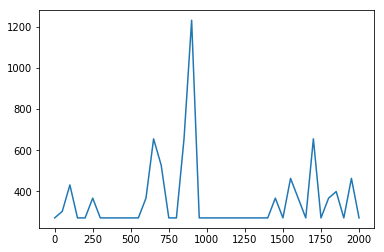

In [24]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [25]:
with open('{}'.format(GAME_NAME.split('/')[1]), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [26]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-06-26 20:36:59,083] Making new env: ppaquette/DoomHealthGathering-v0
[2017-06-26 20:36:59,091] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 20:36:59,334] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14410.video000000.mp4


Episode finished after 75 timesteps with reward=271.0


[2017-06-26 20:37:01,589] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14410.video000001.mp4


Episode finished after 94 timesteps with reward=367.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0
Episode finished after 75 timesteps with reward=271.0


[2017-06-26 20:37:10,969] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14410.video000008.mp4


Episode finished after 113 timesteps with reward=463.0
Episode finished after 151 timesteps with reward=655.0
Episode finished after 75 timesteps with reward=271.0


KeyboardInterrupt: 

In [ ]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
gym.upload('/home/ubuntu/records')

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}.pcl".format(GAME_NAME.split('/')[1]))

In [27]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets